In [1]:
from pystan import StanModel
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
d = pd.read_csv('data-attendance-3.txt')
d = d.drop('PersonID', axis=1)
d.Score/=200
d['W'] = d['Weather'].map({'A': 1.0, 'B': 0.2, 'C': 0.0})
d = d.drop('Weather', axis=1)
data = d.to_dict('list')
data['I'] = len(d)
data;

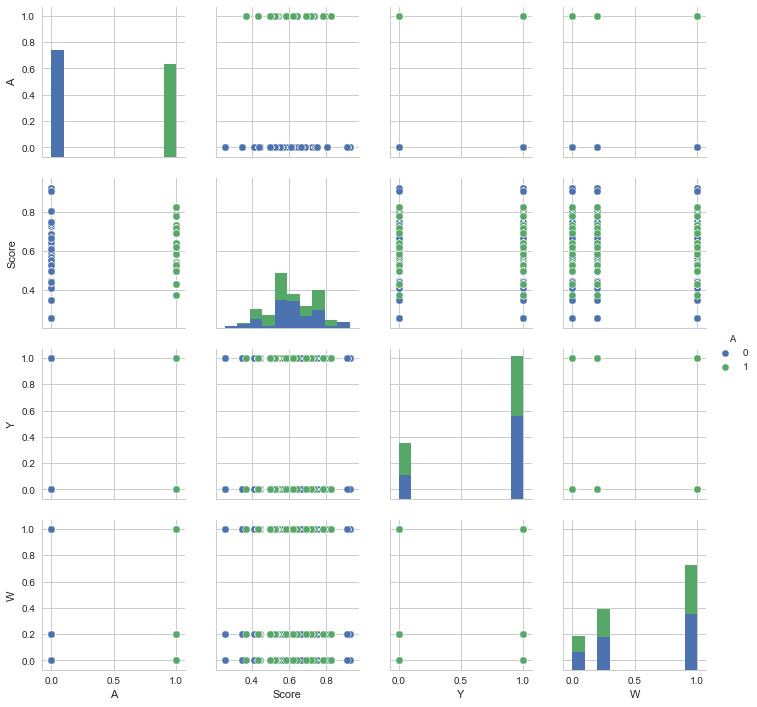

In [4]:
sns.pairplot(d, hue='A');

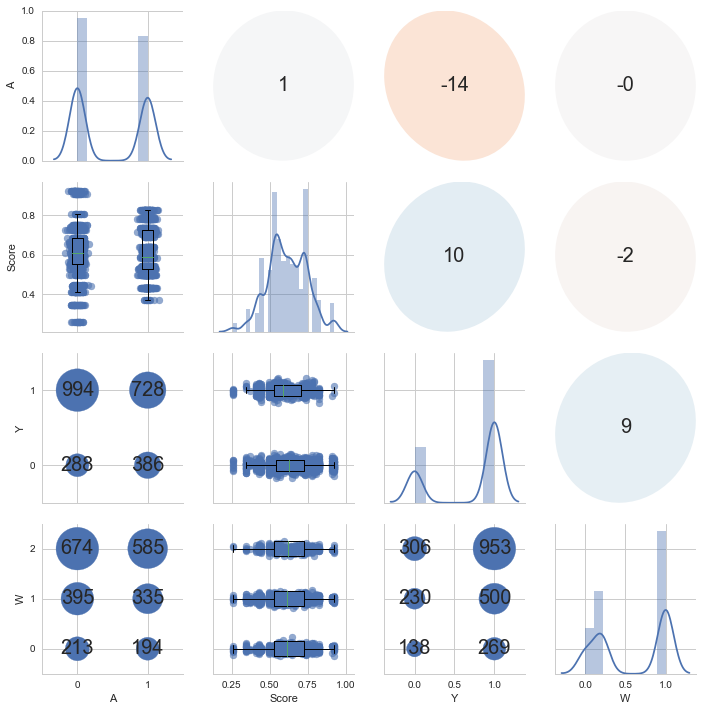

In [5]:
%run Dispatcher.py
g = sns.PairGrid(d, diag_sharey=False)
d_plot = Dispatcher()
# 対角成分
g.map_diag(d_plot.diag)
# 下三角成分
g.map_lower(d_plot.comb);
# 上三角成分
g.map_upper(d_plot.ellipse);

In [7]:
stanmodel = StanModel(file='model5-5.stan')

In [8]:
fit = stanmodel.sampling(data=data, seed=123, thin = 2, warmup=500, n_jobs=-1)

In [9]:
fit

Inference for Stan model: anon_model_655d78c622939e83c319e78bb2e2f96c.
4 chains, each with iter=2000; warmup=500; thin=2; 
post-warmup draws per chain=750, total post-warmup draws=3000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1            -0.22  5.0e-3   0.23  -0.66  -0.38  -0.22  -0.06   0.25   2118    1.0
b2            -0.62  1.8e-3   0.09   -0.8  -0.69  -0.62  -0.56  -0.44   2651    1.0
b3             1.96  7.6e-3   0.36   1.25   1.73   1.96   2.21   2.65   2229    1.0
b4             0.48  2.0e-3    0.1   0.29   0.41   0.48   0.55   0.68   2690    1.0
q[0]           0.63  5.9e-4   0.03   0.58   0.62   0.64   0.65   0.69   2112    1.0
q[1]           0.72  5.0e-4   0.02   0.67    0.7   0.72   0.74   0.77   2306    1.0
q[2]           0.61  6.4e-4   0.03   0.55   0.59   0.61   0.63   0.67   2125    1.0
q[3]           0.72  5.0e-4   0.02   0.67    0.7   0.72   0.74   0.77   2306    1.0
q[4]           0.63  5.9e-4   0.03   0.58   0.62   0.64  

In [10]:
from scipy.stats import gaussian_kde
fit.model_pars.append("lp__")
def find_map(data):
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 501)
    eval_kde = kde.evaluate(x_range)
    return x_range[np.argmax(eval_kde)]

In [11]:
map = []
for i in fit.model_pars:
    print(i)
    if i in fit.constrained_param_names() or i == 'lp__':
        map.append(find_map(fit[i]))
    else:
        for j in range(0, fit[i].shape[1]):
            map.append(find_map(fit[i][:, j]))

b1
b2
b3
b4
q


KeyboardInterrupt: 

In [15]:
def stanfit_to_dataframe(fit):
    summary = fit.summary()
    columns = summary['summary_colnames']
    index = summary['summary_rownames']
    data = summary['summary']
    return pd.DataFrame(data, index, columns)

In [32]:
fitdf = stanfit_to_dataframe(fit)
fitdf;

In [30]:
mc = fit.extract()
df = pd.DataFrame({"b1":mc['b1'], "b2":mc["b2"], "b3":mc["b3"], "b4":mc["b4"], 
             "q1":mc["q"][:, 0], "q2395":mc["q"][:, 2395], "lp__":mc["lp__"]})
df;

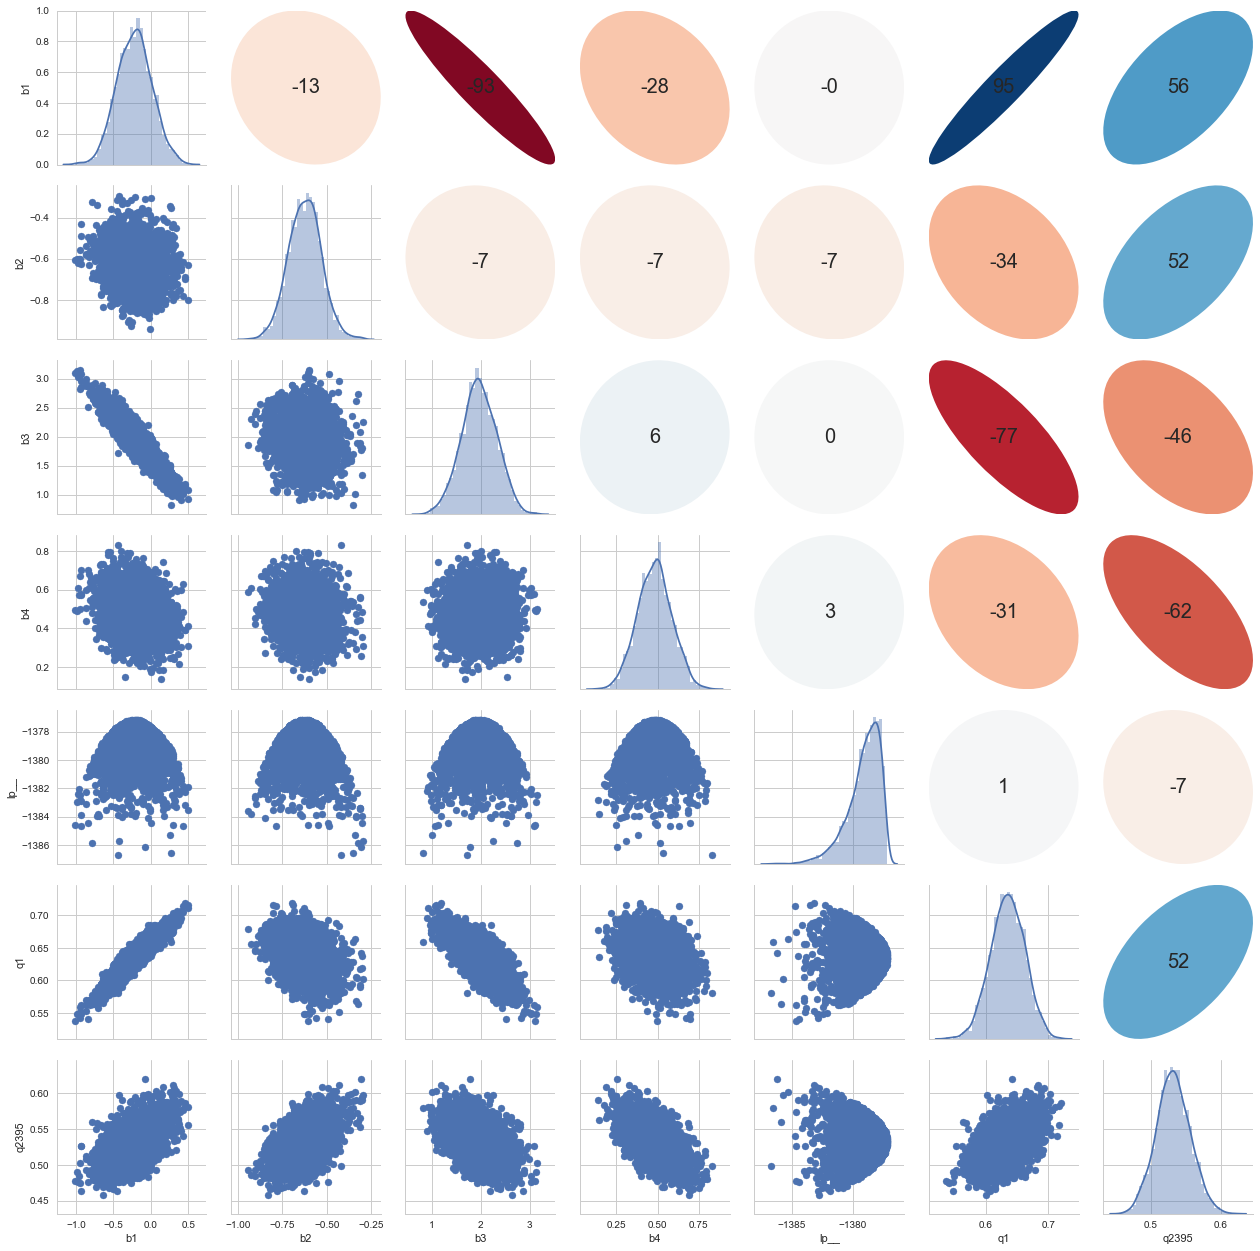

In [19]:
g = sns.PairGrid(df, diag_sharey=False)
d_plot = Dispatcher()
# 対角成分
g.map_diag(d_plot.diag)
# 下三角成分
g.map_lower(d_plot.comb);
# 上三角成分
g.map_upper(d_plot.ellipse);

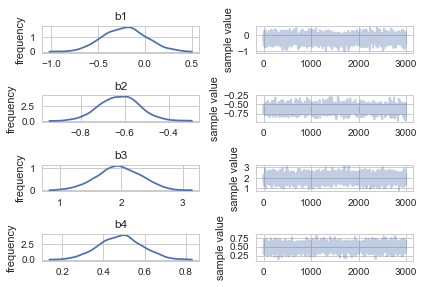

In [20]:
fit.traceplot(pars = ['b1', 'b2', 'b3', 'b4']).tight_layout()

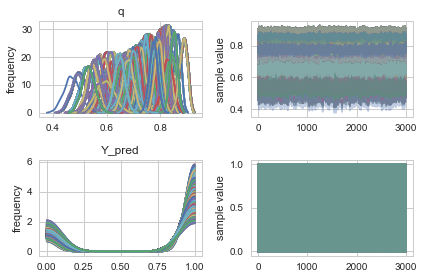

In [21]:
fit.traceplot(pars = ['q', 'Y_pred']).tight_layout()

In [22]:
fitdf_q = fitdf.loc['q[0]': 'q[2395]']
fitdf_Y_pred = fitdf.loc['Y_pred[0]': 'Y_pred[2395]']

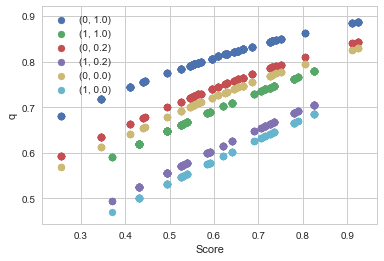

In [28]:
bool_q0 = (d["A"].values == 0)  & (d["W"].values ==1.0)
bool_q1 = (d["A"].values == 1)  & (d["W"].values ==1.0)
bool_q2 = (d["A"].values == 0)  & (d["W"].values ==0.2)
bool_q3 = (d["A"].values == 1)  & (d["W"].values ==0.2)
bool_q4 = (d["A"].values == 0)  & (d["W"].values ==0.0)
bool_q5 = (d["A"].values == 1)  & (d["W"].values ==0.0)
plt.scatter(d[bool_q0].Score, fitdf_q[bool_q0]["mean"], label = '(0, 1.0)')
plt.scatter(d[bool_q1].Score, fitdf_q[bool_q1]["mean"], label = '(1, 1.0)')
plt.scatter(d[bool_q2].Score, fitdf_q[bool_q2]["mean"], label = '(0, 0.2)')
plt.scatter(d[bool_q3].Score, fitdf_q[bool_q3]["mean"], label = '(1, 0.2)')
plt.scatter(d[bool_q4].Score, fitdf_q[bool_q4]["mean"], label = '(0, 0.0)')
plt.scatter(d[bool_q5].Score, fitdf_q[bool_q5]["mean"], label = '(1, 0.0)')
plt.legend()
plt.xlabel('Score')
plt.ylabel('q');